# A single species, single season neural occupancy model

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Assume we have `n` spatial locations, each surveyed `k` times, where each location has some continuous covariate value (e.g., an environmental feature) `x`. 

In [2]:
n = 100
k = 20
x = torch.distributions.uniform.Uniform(low=-torch.ones(n), high=torch.ones(n)).sample()
x, _ = torch.sort(x)
x = x.unsqueeze(1)

Suppose that the detection probability `p`, and the occupancy probability `psi` are polynomial functions of $x$ on the logit (sigmoid) scale. 
Then, simulate true presence/absence states `z`, and binomial observations `y`.

In [3]:
z_dist = torch.distributions.normal.Normal(loc=0, scale=1)
p = torch.sigmoid(z_dist.sample() + z_dist.sample() * x + z_dist.sample() * x**2)
psi = torch.sigmoid(z_dist.sample() + z_dist.sample() * x + z_dist.sample() * x**2)
z = torch.distributions.bernoulli.Bernoulli(probs = psi).sample()
y = torch.distributions.binomial.Binomial(total_count=k, probs=p * z).sample()

Visualize the relationship between the environmental covariate and occupancy and detection probabilities:

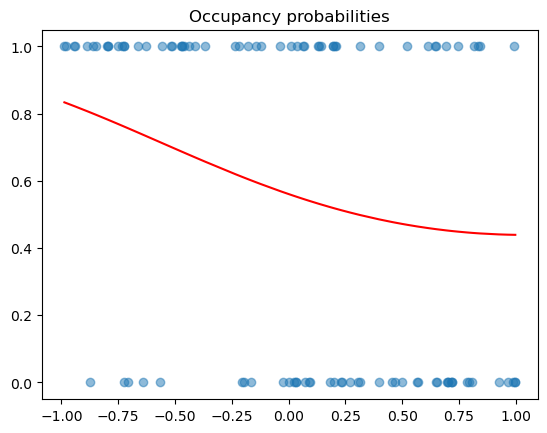

In [4]:
plt.scatter(x.numpy(), z.numpy(), alpha=.5)
plt.plot(x.numpy(), psi.numpy(), color='r')
plt.title('Occupancy probabilities')
plt.show()

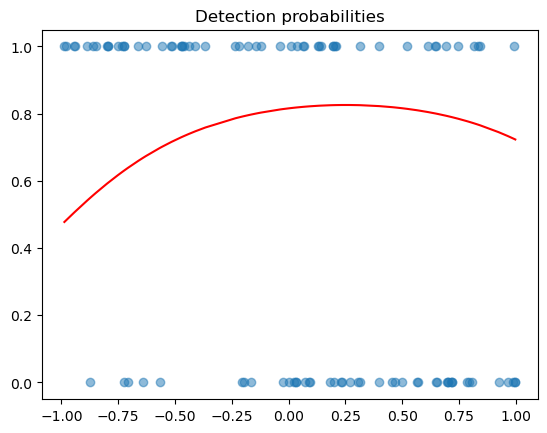

In [5]:
plt.scatter(x.numpy(), 1 * y.numpy() > 0, alpha=.5)
plt.plot(x.numpy(), p.numpy(), color='r')
plt.title('Detection probabilities')
plt.show()

## Defining a model

The model for occupancy probabilities $\psi$ and detection probabilities $p$ is parameterized as a neural network.

A forward pass of the model is:

$x_1 \rightarrow h^{(1)}_{1:64} \rightarrow (\psi_1, p_1),$

where subscripts inidicate the dimensionality, $x$ is input, $h^{(1)}$ is the first hidden layer, and the output is a tuple containing occupancy probability $\psi$ and detection probability $p$.

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = F.elu(self.fc1(x))
        output = torch.sigmoid(self.fc2(x))
        psi = output[:, [0]]
        p = output[:, [1]]
        return psi, p

Instantiate the model object, and send it to the device (the GPU, if one is available). 

In [7]:
net = Net()
net.to(device)
net

Net(
  (fc1): Linear(in_features=1, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

## Training the model

First, set up an empty list to store the loss (negative log likelihood) at each training iteration:

In [8]:
running_loss = list()

Then, choose an optimizer, a value for the $L_2$ norm penalty on the parameters (the `weight_decay` argument), and the number of times to iterate over the dataset (`n_epoch`).

In [9]:
optimizer = optim.Adam(net.parameters(), weight_decay=1e-8)
n_epoch = 200

Training models is easier in Pytorch when a `DataLoader` object is defined. In this case, we will create a `DataLoader` with settings defined in the `params` dictionary:

- `batch_size`: the number of examples to load on each training iteration
- `shuffle`: whether to shuffle the examples for each epoch
- `num_workers`: the number of CPU cores to use to load data

In [10]:
params = {'batch_size': 32,
          'shuffle': True,
          'num_workers': 1}

dataset = TensorDataset(x, y)
dataloader = DataLoader(dataset, **params)

Now, iterate over training epochs, and within epochs, over minibatches. This training loop includes calculations of the negative log likelihood (`loss`).

In [11]:
for i in tqdm(range(n_epoch)):
    for i_batch, xy in enumerate(dataloader):
        # load a minibatch
        x_i, y_i = xy
        x_i = x_i.to(device)
        y_i = y_i.to(device)
        
        # zero out the gradients
        optimizer.zero_grad()
        
        # determine for each example whether we know if z = 1
        definitely_present = (y_i > 0).to(device, dtype=torch.float32)
        maybe_absent = (y_i == 0).to(device, dtype=torch.float32)

        # generate estimates of psi and p from teh model
        psi_i, p_i = net(x_i)

        # compute the loss (negative log likelihood)
        y_dist_if_present = torch.distributions.binomial.Binomial(total_count=k, probs=p_i)
        lp_present = torch.log(psi_i) + y_dist_if_present.log_prob(y_i)
        lp_maybe_absent = torch.logsumexp(torch.cat((lp_present, torch.log(1 - psi_i)), dim=1), 
                                          dim=1)
        log_prob = definitely_present * lp_present + maybe_absent * lp_maybe_absent

        loss = -torch.mean(log_prob)
        loss.backward()
        optimizer.step()
        running_loss.append(loss.cpu().data.numpy())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:06<00:00, 32.36it/s]


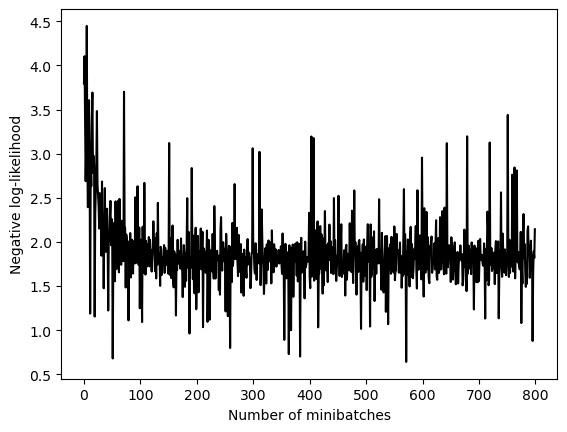

In [12]:
plt.plot(np.arange(len(running_loss)), running_loss, c='k')
plt.xlabel("Number of minibatches")
plt.ylabel("Negative log-likelihood")
plt.show()

# Making predictions

Now, let's see what the model predicts as a function of `x` for the training data.

In [13]:
psi_hat, p_hat = net(x.to(device))

Here, the true parameter values from the generative model will be shown in black, and predicted parameter values from the model in red. 

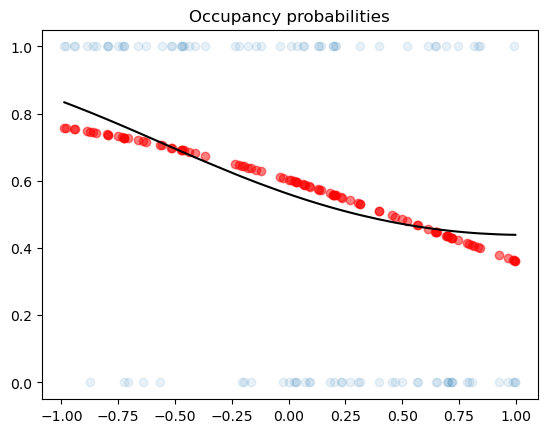

In [14]:
plt.scatter(x.numpy(), z.numpy(), alpha=.1)
plt.scatter(x.numpy(), psi_hat.cpu().detach().numpy(), color='r', alpha=.5)
plt.plot(x.numpy(), psi.numpy(), color='k')
plt.title('Occupancy probabilities')
plt.show()

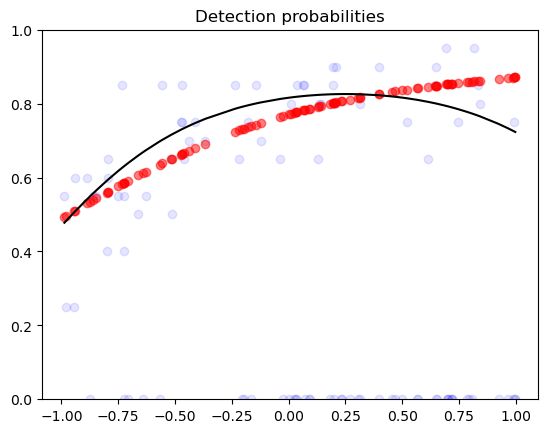

In [15]:
plt.scatter(x.numpy(), y.numpy() / k, alpha = .1, color = 'b')
plt.scatter(x.numpy(), p_hat.cpu().detach().numpy(), alpha=.5, color='r')
plt.plot(x.numpy(), p.numpy(), color='k')
plt.title('Detection probabilities')
plt.ylim(0, 1)
plt.show()